# ML-with-python Capstone Project

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
import seaborn as sns

To download dataset

In [75]:
#!wget -O loan_train.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv

## Data description
This dataset is about past loans. The **Loan_train.csv** data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
| -------------- | ------------------------------------------------------------------------------------- |
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


## Data Cleansing and Preparation

- Data transformation from catagorical to numerical
- Rmoving unnecessary/unrelavent data or features

### Data Structure 

In [76]:
df = pd.read_csv('loan_train.csv')
print(f'Shape of dataset : {df.shape}.\n')
print(f'Data types :\n{df.dtypes}\n')
print(f'Columns: \n{df.columns}')


Shape of dataset : (346, 10).

Data types :
Unnamed: 0         int64
Unnamed: 0.1       int64
loan_status       object
Principal          int64
terms              int64
effective_date    object
due_date          object
age                int64
education         object
Gender            object
dtype: object

Columns: 
Index(['Unnamed: 0', 'Unnamed: 0.1', 'loan_status', 'Principal', 'terms',
       'effective_date', 'due_date', 'age', 'education', 'Gender'],
      dtype='object')


In [77]:
print(f'Data structure: \n')
df.head()

Data structure: 



,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


### Visualization of some features

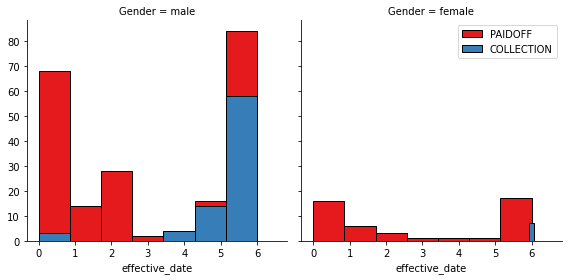

In [78]:
df['effective_date'] = pd.to_datetime(df['effective_date'])
df['effective_date'] = df['effective_date'].dt.dayofweek

bins = np.linspace(df.effective_date.min(), df.effective_date.max(),7)
#fig, axes = plt.subplots(2,2, figsize=(20,20))
gp = sns.FacetGrid(df, col='Gender',
                   hue='loan_status',
                   palette='Set1',
                   col_wrap=2, 
                   height=4,
                   aspect=1.0 )
gp.map(plt.hist, 'effective_date', bins=len(bins), ec='k')
#gp.figure.savefig('delet_1.png')
gp.axes[1].legend()

It seems, who got the loan begining of the week they are pay their loan off. Let's do feature binarization with a threshold value 3.

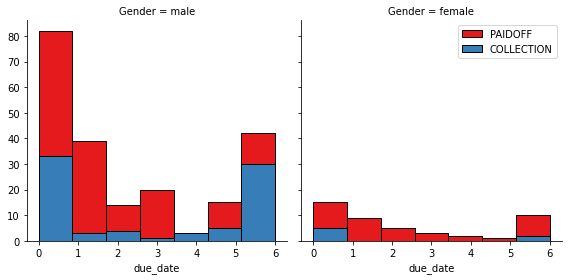

In [79]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['due_date'] = df['due_date'].dt.dayofweek

bins = np.linspace(df.due_date.min(), df.due_date.max(),7)
gp = sns.FacetGrid(df, col='Gender',
                   hue='loan_status',
                   palette='Set1',
                   col_wrap=2,
                   height=4,
                   aspect=1.0)

gp.map(plt.hist, 'due_date', bins=len(bins), ec='k')
gp.axes[-1].legend()

There is no such epecific pattern for **'loan_status'** regarding **'due_data'**. Thus we can skip this data column.

Only two data samples are member of 'Master or Above' subclass, Therefore we can exclude the this subclass from our dataset. Oneway to do it transform these subclass, e.g. **'college', Bechalor**, into featurs label. 

In [80]:
df['Principal'].value_counts(),df['terms'].value_counts()

(1000    258
 800      81
 300       3
 900       2
 500       2
 Name: Principal, dtype: int64,
 30    184
 15    148
 7      14
 Name: terms, dtype: int64)

### Preparation of features and terget

In [81]:
# 0-> for the first 4 days
# 1-> for the last 3 days
df['effective_date'] = df['effective_date'].apply(lambda x: 1 if (x>3)  else 0)
df.drop('due_date', axis=1, inplace=True)

Feature = df[['loan_status', 'Principal', 'terms', 'effective_date', 
              'age', 'education', 'Gender']]
# Removin the data sample with Master or Above

Feature = Feature[Feature['education']!='Master or Above']
Feature = Feature[Feature['Principal'] >= 800]
#Feature = Feature[Feature['terms'] > 7]
#Feature = pd.concat([Feature, pd.get_dummies(df['education'])], axis=1)
#Feature.drop(['Master or Above'], axis=1, inplace=True)

Feature['education'].replace(to_replace=['High School or Below', 
                                         'Bechalor', 'college'], 
                               value=[0,1,2], inplace=True)
le_gender = preprocessing.LabelEncoder().fit(['female', 'male'])
Feature['Gender']= le_gender.transform(Feature['Gender'])
Feature['loan_status'].replace(to_replace=['PAIDOFF', 'COLLECTION'], 
                               value=[1,0], inplace=True)
X = Feature.drop(['loan_status'], axis=1)
y = Feature['loan_status']

In [82]:
Feature.head()

,loan_status,Principal,terms,effective_date,age,education,Gender
0,1,1000,30,0,45,0,1
1,1,1000,30,0,33,1,0
2,1,1000,15,0,27,2,1
3,1,1000,30,1,28,2,0
4,1,1000,30,1,29,2,1


## Data Normalization and Train-test spliting

In [97]:
from sklearn.model_selection import train_test_split
X[['Principal', 'terms', 'age',]] = preprocessing.StandardScaler().fit(X[['Principal','terms', 'age',]]
                                                                      ).transform(X[['Principal', 'terms', 'age',]])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,)

## Classification Algorithm
### K-Nearest Neighbour

In [98]:
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import jaccard_score, f1_score, log_loss, confusion_matrix

In [108]:
k = range(20)[3:]
jac_metrics = []
log_metrics = []
f1_metrics = []
for i in k: 
    
    knc = KNeighborsClassifier(n_neighbors=i, p=2)
    knc.fit(X_train, y_train)
    y_hat = knc.predict(X_test)
    
    ja = jaccard_score(y_true=y_test, y_pred=y_hat)
    jac_metrics.append(ja)
    ll = 1-log_loss(y_true=y_test, y_pred=y_hat) /len(y_test)
    log_metrics.append(ll)
    f1 = f1_score(y_true=y_test, y_pred=y_hat)
    f1_metrics.append(f1)

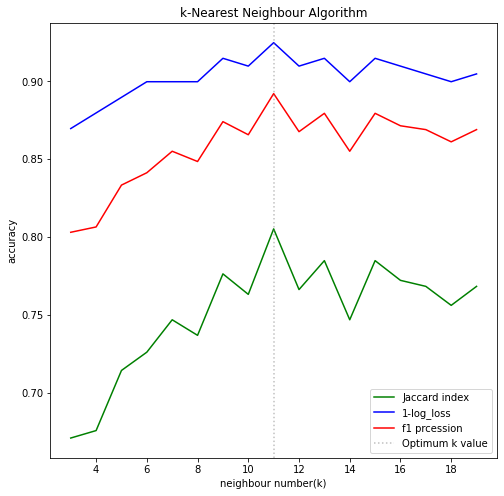

In [109]:
k_best = []
k_best.append(k[jac_metrics.index(max(jac_metrics))])
k_best.append(k[log_metrics.index(max(log_metrics))])
k_best.append(k[f1_metrics.index(max(f1_metrics))])
k_best = max(k_best, key = k_best.count)

plt.figure(figsize=(8,8))
plt.plot(k, jac_metrics, 'g', label='Jaccard index')
plt.plot(k, log_metrics, 'b', label='1-log_loss')
plt.plot(k, f1_metrics, 'r', label='f1 prcession')
plt.xlabel('neighbour number(k)')
plt.ylabel('accuracy')
plt.title('k-Nearest Neighbour Algorithm')
plt.axvline(k_best, ls=':', alpha=0.5, color='gray', label='Optimum k value')
plt.legend()

#### Calclating the confusion matrix

In [110]:
knc = KNeighborsClassifier(n_neighbors=k_best, p=2)
knc.fit(X_train, y_train)
y_hat = knc.predict(X_test)

Conf_matr = np.zeros(shape=(2,2), dtype=int)
for (i,j) in zip(y_test, y_hat):
    if i==0:
        if j==0:
            Conf_matr[0,0] = Conf_matr[0, 0] + 1
        else:
            Conf_matr[0,1] = Conf_matr[0, 1] + 1
    else:
        if j==0: 
            Conf_matr[1,0] = Conf_matr[1,0] + 1
        else:
            Conf_matr[1,1] = Conf_matr[1,1] + 1
#Conf_matr==confusion_matrix(y_true=y_test, y_pred=y_hat)

In [111]:
ja = jaccard_score(y_true=y_test, y_pred=y_hat)
ll = 1-log_loss(y_true=y_test, y_pred=y_hat) /len(y_test)
f1 = f1_score(y_true=y_test, y_pred=y_hat)

print(' Metrics for KNeighborsClassifier --')
print(' Jaccard score : ', ja)
print(' 1-logloss : ', ll)
print(' F1 score : ', f1)

 Metrics for KNeighborsClassifier --
 Jaccard score :  0.8051948051948052
 1-logloss :  0.9247941877939203
 F1 score :  0.8920863309352517


In [112]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 6 14]
 [ 1 62]]


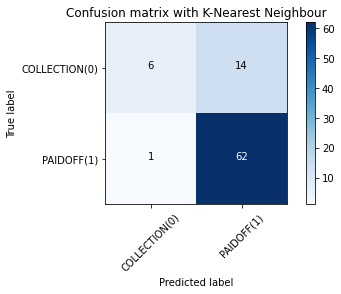

In [113]:
plot_confusion_matrix(cm=Conf_matr,
                      title='Confusion matrix with K-Nearest Neighbour',
                       classes=['COLLECTION(0)', 'PAIDOFF(1)'])

### Decision Tree Algorithm

In [114]:
from sklearn.tree import DecisionTreeClassifier
criterion = 'gini'#'entropy'
dtc = DecisionTreeClassifier(criterion=criterion)
dtc.fit(X_train, y_train)
y_hat = dtc.predict(X_test)


In [115]:
ja = jaccard_score(y_true=y_test, y_pred=y_hat)
ll = 1-log_loss(y_true=y_test, y_pred=y_hat) /len(y_test)
f1 = f1_score(y_true=y_test, y_pred=y_hat)

print(' Metrics for Decision Tree Algorithm--')
print(' Jaccard score : ', ja)
print(' 1-logloss : ', ll)
print(' F1 score : ', f1)

 Metrics for Decision Tree Algorithm--
 Jaccard score :  0.618421052631579
 1-logloss :  0.854603729101611
 F1 score :  0.7642276422764228


In [116]:
y_test.value_counts()

1    63
0    20
Name: loan_status, dtype: int64

#### Calclating the confusion matrix

Confusion matrix, without normalization
[[ 7 13]
 [16 47]]


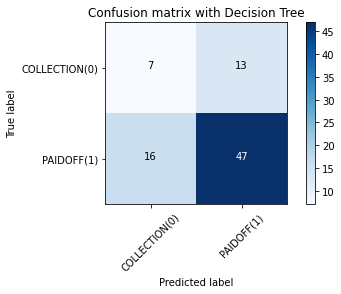

In [118]:
Conf_matr = confusion_matrix(y_true=y_test, 
                 y_pred=y_hat)

plot_confusion_matrix(cm=Conf_matr,
                      title='Confusion matrix with Decision Tree',
                      classes=['COLLECTION(0)', 'PAIDOFF(1)'])

### Support Vector Machine Algorithm

#### With rbf kernel

In [119]:
from sklearn import svm
svm_al = svm.SVC(kernel='rbf', gamma='scale')
svm_al.fit(X_train, y_train)

y_hat = svm_al.predict(X_test)

In [120]:
ja = jaccard_score(y_true=y_test, y_pred=y_hat)
ll = 1-log_loss(y_true=y_test, y_pred=y_hat) /len(y_test)
f1 = f1_score(y_true=y_test, y_pred=y_hat)

print(' Metrics for Support Vector Machine with rbf kernel --')
print(' Jaccard score : ', ja)
print(' 1-logloss : ', ll)
print(' F1 score : ', f1)

 Metrics for Support Vector Machine with rbf kernel --
 Jaccard score :  0.7590361445783133
 1-logloss :  0.8997254289669302
 F1 score :  0.8630136986301369


#### Calclating the confusion matrix

Confusion matrix, without normalization
[[ 0 20]
 [ 0 63]]


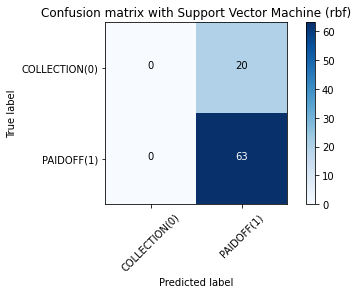

In [122]:
Conf_matr = confusion_matrix(y_true=y_test, 
                 y_pred=y_hat)

plot_confusion_matrix(cm=Conf_matr,
                      title='Confusion matrix with Support Vector Machine (rbf)',
                      classes=['COLLECTION(0)', 'PAIDOFF(1)'])

#### With polynomial (poly) kernel

In [123]:
#{'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'}
from sklearn import svm
svm_al = svm.SVC(kernel='poly', degree=9)
svm_al.fit(X_train, y_train)

y_hat = svm_al.predict(X_test)

In [124]:
ja = jaccard_score(y_true=y_test, y_pred=y_hat)
ll = 1-log_loss(y_true=y_test, y_pred=y_hat) /len(y_test)
f1 = f1_score(y_true=y_test, y_pred=y_hat)

print(' Metrics for Support Vector Machine with poly kernel --')
print(' Jaccard score : ', ja)
print(' 1-logloss : ', ll)
print(' F1 score : ', f1)

 Metrics for Support Vector Machine with poly kernel --
 Jaccard score :  0.7283950617283951
 1-logloss :  0.8896984361385137
 F1 score :  0.842857142857143


Confusion matrix, without normalization
[[ 2 18]
 [ 4 59]]


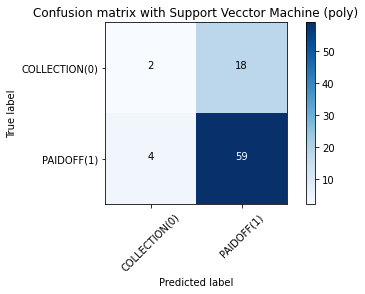

In [125]:
Conf_matr = confusion_matrix(y_true=y_test, 
                 y_pred=y_hat)

plot_confusion_matrix(cm=Conf_matr,
                      title='Confusion matrix with Support Vecctor Machine (poly)',
                      classes=['COLLECTION(0)', 'PAIDOFF(1)'])

### Clssification with Logistic Regression

In [126]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
lr = LogisticRegression(C=0.1, solver='liblinear').fit(X_train,y_train)

y_hat = lr.predict(X_test)

In [127]:
ja = jaccard_score(y_true=y_test, y_pred=y_hat)
ll = 1-log_loss(y_true=y_test, y_pred=y_hat) /len(y_test)
f1 = f1_score(y_true=y_test, y_pred=y_hat)

print(' Metrics for Support Vector Machine with poly kernel --')
print(' Jaccard score : ', ja)
print(' 1-logloss : ', ll)
print(' F1 score : ', f1)

 Metrics for Support Vector Machine with poly kernel --
 Jaccard score :  0.7590361445783133
 1-logloss :  0.8997254289669302
 F1 score :  0.8630136986301369


Confusion matrix, without normalization
[[ 0 20]
 [ 0 63]]


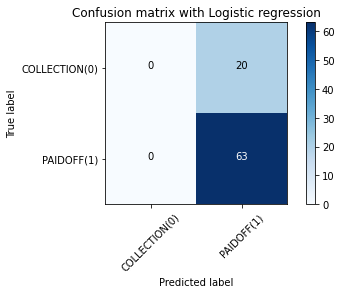

In [129]:
Conf_matr = confusion_matrix(y_true=y_test, 
                 y_pred=y_hat)

plot_confusion_matrix(cm=Conf_matr,
                      title='Confusion matrix with Logistic regression',
                      classes=['COLLECTION(0)', 'PAIDOFF(1)'])

## Observation and Conclusion
- Data cleansing and preparation is important part of ML as it improves the results. For example removing two samples corresponds to the `education[Master or Above`] and five samples associated with `Principle[<800]` improves the confusion matrix, though the changes in the accuracy is not significant.
- The metrics discussed here give almost the same accuracy over different attempts.
- Significant changes in confusion matrix have observed over the different attempts, e.g. on some attempts the confusion matrix gives better result in both `PAIDOFF(1)` and `COLLECION(0)` and on other attempts better result comes only in qestion of `PAIDOFF`.
- Regarding the overall performances, the algorithm Decision Tree renders better prediction.  
- Cross-validation might be a resovent for point(3) which will improve the parameters( $\large{\theta}$ from the expression $\large{\theta}^\intercal\large{x}$ ) implementing algorithm over the attempts. 